In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/get/3_k562_finetune")
print(os.getcwd())

/gpfs/group/jin/asun/get/3_k562_finetune


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [13]:
celltype_for_modeling = ['k562']

cfg = load_config('finetune_tutorial') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.run_name = 'k562_embedding'
cfg.dataset.quantitative_atac = False # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = "./k562.zarr" # set the path to the data zarr file we just processed
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to finetune
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_chromosomes = '' # set the celltypes you want to leave out
cfg.dataset.leave_out_celltypes = '' # set the celltypes you want to leave out
cfg.machine.num_devices=1 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory
cfg.training.epochs=50
cfg.machine.output_dir = '/gpfs/home/asun/jin_lab/get/3_k562_finetune'
cfg.run.run_name = 'noLO_embedding'
#cfg.machine.output_dir = "./output/"
print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /gpfs/home/asun/jin_lab/get/3_k562_finetune/finetune_tutorial/noLO_embedding
training for 50 epochs


In [4]:
{cfg.machine.output_dir}

{'/gpfs/home/asun/jin_lab/get/3_k562_finetune'}

In [14]:
# export the config to a yaml file
from get_model.config.config import export_config, load_config_from_yaml

export_config(cfg, "finetune_config.yaml")

In [15]:
# load the config from the yaml file
cfg = load_config_from_yaml("finetune_config.yaml")
cfg.stage='validate'

In [8]:
print(f"Default checkpoint path is at: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}/checkpoints/best.ckpt")
print("The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training")

Default checkpoint path is at: /gpfs/home/asun/jin_lab/get/3_k562_finetune/finetune_aggr_multiome/noLO_embedding/checkpoints/best.ckpt
The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/get_model/utils.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via thi

Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model
PearsonRResult(statistic=np.float32(0.014050678), pvalue=np.float64(0.005238180558521052))


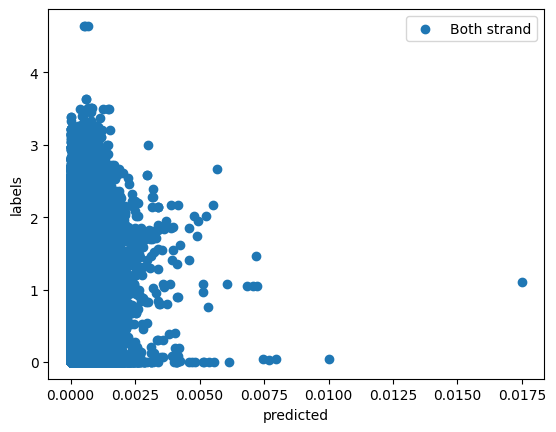

In [10]:
from get_model.dataset.zarr_dataset import RegionMotifDataset, InferenceRegionMotifDataset
import torch
import logging
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from hydra.utils import instantiate

from get_model.dataset.zarr_dataset import RegionMotifDataset
from get_model.config.config import load_config_from_yaml
from get_model.utils import load_checkpoint, extract_state_dict, rename_state_dict, load_state_dict

def get_model(cfg):
    model = instantiate(cfg.model)

    # Load main model checkpoint
    if cfg.finetune.checkpoint is not None:
        checkpoint_model = load_checkpoint(
            cfg.finetune.checkpoint, model_key=cfg.finetune.model_key
        )
        checkpoint_model = extract_state_dict(checkpoint_model)
        checkpoint_model = rename_state_dict(
            checkpoint_model, cfg.finetune.rename_config
        )
        load_state_dict(
            model, checkpoint_model, strict=cfg.finetune.strict
        )

    # Load additional checkpoints
    if len(cfg.finetune.additional_checkpoints) > 0:
        for checkpoint_config in cfg.finetune.additional_checkpoints:
            checkpoint_model = load_checkpoint(
                checkpoint_config.checkpoint, model_key=checkpoint_config.model_key
            )
            checkpoint_model = extract_state_dict(checkpoint_model)
            checkpoint_model = rename_state_dict(
                checkpoint_model, checkpoint_config.rename_config
            )
            load_state_dict(
                model, checkpoint_model, strict=checkpoint_config.strict
            )

    model.freeze_layers(
        patterns_to_freeze=cfg.finetune.patterns_to_freeze, invert_match=False
    )
    logging.debug("Model = %s" % str(model))
    return model


# load the config from the yaml file
cfg = load_config_from_yaml("finetune_config.yaml")
cfg.stage='validate'

# Load dataset
dataset = RegionMotifDataset(
    **cfg.dataset,
    is_train=False,
)

# Create DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg.machine.batch_size,
    num_workers=cfg.machine.num_workers,
    drop_last=False,
    shuffle=False,
)

# Load model
model = get_model(cfg)
model.eval()

results = []
labels = []
with torch.no_grad():
    for batch in dataloader:
        tss_mask = batch['mask'].numpy()
        outputs = model(batch['region_motif']).numpy()[tss_mask>0]
        if len(outputs)>0:
            results.extend(outputs)
            labels.extend(batch['exp_label'].numpy()[tss_mask>0])
results = np.array(results)
labels = np.array(labels)
plt.figure()
plt.scatter(results, labels, label='Both strand')
plt.legend()
plt.xlabel('predicted')
plt.ylabel('labels')

print(pearsonr(results, labels))


In [76]:
from gcell.rna.gencode import Gencode
from get_model.dataset.zarr_dataset import InferenceRegionMotifDataset
gencode_obj = {'hg38': Gencode(assembly='hg38')}
infer_dataset = InferenceRegionMotifDataset(
    assembly='hg38',
    gencode_obj=gencode_obj,
    gene_list=['Plpp3'],
    zarr_path='./aggr_multiome.zarr',
    celltypes='Endo',
    transform=None,
    quantitative_atac=True,
    sampling_step=100,
    num_region_per_sample=200,
    leave_out_celltypes='Endo',
    mask_ratio=0.0,
    is_train=False,
)


100%|██████████| 1/1 [00:00<00:00, 49.08it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


In [57]:
print(infer_dataset)

In [77]:
infer_dataset[0]['region_motif'][:, -1]

array([0.08713102, 0.16214019, 0.16214019, 0.08713102, 0.2678179 ,
       0.13008109, 0.06894679, 0.138276  , 0.06894679, 0.08713102,
       0.12175992, 0.05961991, 0.07811542, 0.18499452, 0.06894679,
       0.11330861, 0.04046857, 0.06894679, 0.14634842, 0.23483694,
       0.05012909, 0.02061315, 0.05012909, 0.06894679, 0.14634842,
       0.05012909, 0.09599855, 0.1774833 , 0.03063209, 0.08713102,
       0.11330861, 0.13008109, 0.04046857, 0.11330861, 0.5726132 ,
       0.28046635, 0.14634842, 0.12175992, 0.12175992, 0.16214019,
       0.08713102, 0.15430202, 0.11330861, 0.05961991, 0.3878198 ,
       0.1698662 , 0.1774833 , 0.1774833 , 0.24159624, 0.10472292,
       0.06894679, 0.07811542, 0.13008109, 0.22105931, 0.11330861,
       0.24827196, 0.09599855, 0.22105931, 0.10472292, 0.05012909,
       0.14634842, 0.06894679, 0.10472292, 0.02061315, 0.11330861,
       0.13008109, 0.19240265, 0.08713102, 0.05961991, 0.10472292,
       0.06894679, 0.138276  , 0.05961991, 0.05961991, 0.21403

In [79]:
infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset,
    batch_size=cfg.machine.batch_size,
    num_workers=cfg.machine.num_workers,
    drop_last=False,
    shuffle=False,
)

In [80]:
batch['region_motif'].shape

torch.Size([4, 200, 283])

In [86]:
for batch in infer_dataloader:
    print(batch)
    outputs = model(batch['region_motif']).detach().numpy()
    print(outputs.shape)
    break

{'region_motif': tensor([[[0.0000, 0.0000, 0.0528,  ..., 0.0301, 0.0127, 0.0871],
         [0.0000, 0.0000, 0.0377,  ..., 0.0927, 0.0000, 0.1621],
         [0.0000, 0.0000, 0.0000,  ..., 0.0363, 0.0000, 0.1621],
         ...,
         [0.0000, 0.0000, 0.0433,  ..., 0.0425, 0.0000, 0.2989],
         [0.0000, 0.0000, 0.0334,  ..., 0.0912, 0.0544, 0.3616],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0089, 0.1621]]]), 'mask': tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
       

In [83]:
outputs1 = model(batch['region_motif']).detach().numpy()
perturb_data = batch['region_motif'].clone()
perturb_data[:, 98:103, :] = 0
outputs2 = model(perturb_data).detach().numpy()



In [84]:
perturb_coords = batch['peak_coord'][0, 98:103, :].sum(axis=1)/2
perturb_coords = perturb_coords.numpy()
chrom = batch['chromosome']

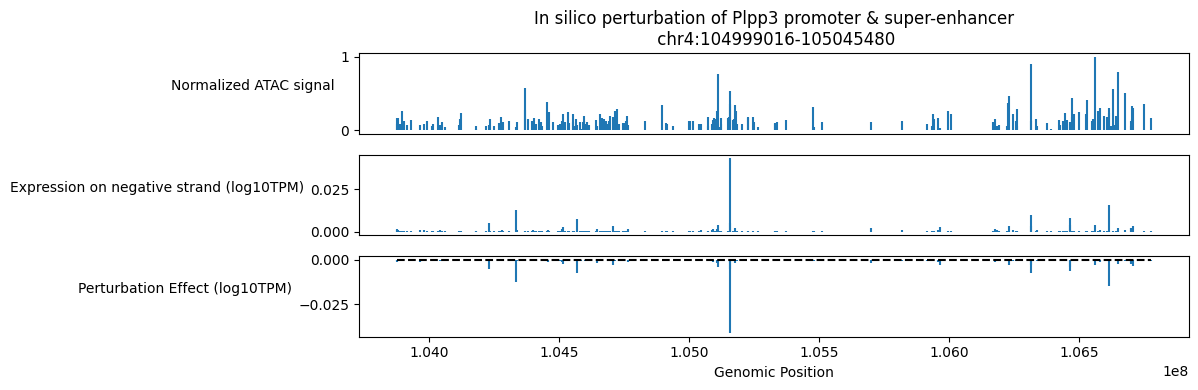

In [87]:
# Create a lollipop plot to visualize the difference between perturbed and original outputs
fig, ax = plt.subplots(3, 1, figsize=(12, 4))
x_coords = batch['peak_coord'][0].sum(axis=1).numpy()/2
y_values = outputs2[0, :, 1]-outputs1[0, :, 1]

# plot the atac signal
ax[0].stem(x_coords, batch['region_motif'][0, :, -1].numpy(), markerfmt='', linefmt='-', basefmt=' ')
# plot the original expression
ax[1].stem(x_coords, outputs1[0, :, 1], markerfmt='', linefmt='-', basefmt=' ')
# Plot the stems (lines)
ax[2].stem(x_coords, y_values, markerfmt='', linefmt='-', basefmt=' ')

# remove the x axis labels for the first two plots
ax[0].set_xticks([])
ax[1].set_xticks([])


# Customize the plot
ax[0].set_ylabel('Normalized ATAC signal', rotation=0, ha='right')
ax[1].set_ylabel('Expression on negative strand (log10TPM)', rotation=0, ha='right')
ax[2].set_xlabel('Genomic Position')
ax[2].set_ylabel('Perturbation Effect (log10TPM)', rotation=0, ha='right')
ax[0].set_title('In silico perturbation of Plpp3 promoter & super-enhancer\n %s' % str(chrom[0]+ ':'+ str(int(perturb_coords[0])) + '-' + str(int(perturb_coords[-1]))))
# change the 1e8 in x axis label to Mb
ax[2].hlines(0, x_coords[0], x_coords[-1], color='black', linestyle='--')
plt.tight_layout()
plt.show()




Now we can start the finetuning

In [18]:
cfg

{'run': {'project_name': 'finetune_tutorial', 'run_name': 'noLO_embedding', 'use_wandb': True}, 'type': 'region', 'stage': 'validate', 'assembly': 'hg38', 'eval_tss': True, 'log_image': True, 'model': {'_target_': 'get_model.model.model.GETRegionFinetune', 'cfg': {'num_regions': 900, 'num_motif': 283, 'embed_dim': 768, 'num_layers': 12, 'num_heads': 12, 'dropout': 0.1, 'output_dim': 2, 'flash_attn': False, 'pool_method': 'mean', 'region_embed': {'num_regions': '${model.cfg.num_regions}', 'num_features': '${model.cfg.num_motif}', 'embed_dim': '${model.cfg.embed_dim}'}, 'encoder': {'num_heads': '${model.cfg.num_heads}', 'embed_dim': '${model.cfg.embed_dim}', 'num_layers': '${model.cfg.num_layers}', 'drop_path_rate': '${model.cfg.dropout}', 'drop_rate': 0, 'attn_drop_rate': 0, 'use_mean_pooling': False, 'flash_attn': '${model.cfg.flash_attn}'}, 'head_exp': {'embed_dim': '${model.cfg.embed_dim}', 'output_dim': '${model.cfg.output_dim}', 'use_atac': False}, 'mask_token': {'embed_dim': '${mo

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/get_model/utils.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted 

Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/home/asun/miniforge3/envs/get/lib/python3.12/s ...
  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        exp_pearson        │   -0.009337727911770344   │
│          exp_r2           │    -1.2834677696228027    │
│       exp_spearman        │   -0.010258984751999378   │
│       val_exp_loss        │    0.3781699538230896     │
│         val_loss          │    0.3781699538230896     │
└───────────────────────────┴───────────────────────────┘

epoch,▁
exp_pearson,▁
exp_r2,▁
exp_spearman,▁
trainer/global_step,▁▁
val_exp_loss,▁
val_loss,▁
epoch,0
exp_pearson,-0.00934
exp_r2,-1.28347
exp_spearman,-0.01026


checkpoint path: 


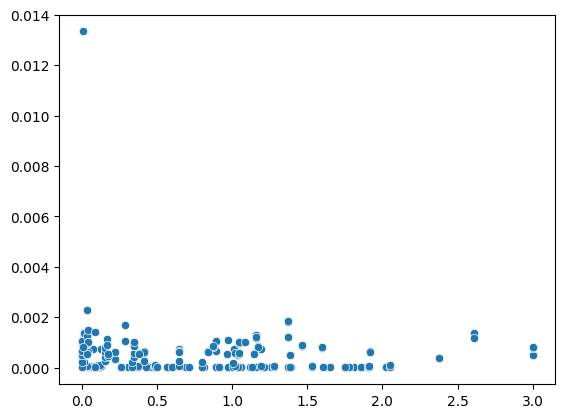

In [16]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
cfg.machine.batch_size=8
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)

In [89]:
cfg.stage='predict'
cfg.dataset.leave_out_chromosomes=''
cfg.task.gene_list = None
cfg.task.test_mode = 'interpret'
cfg.task.layer_names = ['region_embed', 'encoder.blocks.0', 'encoder.blocks.1', 'encoder.blocks.2', 'encoder.blocks.3', 'encoder.blocks.4', 
                        'encoder.blocks.5', 'encoder.blocks.6', 'encoder.blocks.7', 'encoder.blocks.8', 'encoder.blocks.9', 'encoder.blocks.10',
                        'encoder.blocks.11', 'encoder.norm']
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/get_model/utils.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted 

Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/home/asun/miniforge3/envs/get/lib/python3.12/s ...
  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/get_model/run.py:416: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if layer.grad is not None:
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /gpfs/home/asun/jin_lab/get/3_aggr_embedding/finetune_aggr_multiome/noLO_embedding/Endo.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])


/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/zarr/storage.py:455: UserWarning: an object_codec is only needed for object arrays
  _init_array_metadata(


Saving batch of results to /gpfs/home/asun/jin_lab/get/3_aggr_embedding/finetune_aggr_multiome/noLO_embedding/Endo.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
Saving batch of results to /gpfs/home/asun/jin_lab/get/3_aggr_embedding/finetune_aggr_multiome/noLO_embedding/Endo.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available_genes'])
Saving batch of results to /gpfs/home/asun/jin_lab/get/3_aggr_embedding/finetune_aggr_multiome/noLO_embedding/Endo.zarr
dict_keys(['preds', 'obs', 'jacobians', 'input', 'embeddings', 'chromosome', 'peak_coord', 'strand', 'focus', 'available

In [1]:
import zarr
z = zarr.open('/gpfs/home/asun/jin_lab/get/3_aggr_embedding/finetune_aggr_multiome/noLO_embedding/Endo.zarr')


In [28]:
print(z)

<zarr.hierarchy.Group '/'>


In [43]:
sum((z['expression_positive/Endo'][:]+z['expression_negative/Endo'][:])>0)

KeyError: 'expression_positive/Endo'

In [6]:
z['embeddings/region_embed'][:].shape

(4109, 200, 768)

In [7]:
z['embeddings/encoder.blocks.8'][:].shape

(4109, 768)

In [2]:
# umap
import umap
umap_result = umap.UMAP(n_components=2).fit_transform(
    z['embeddings/encoder.blocks.8'][:]
    )
# plot the umap


In [3]:
umap_result

array([[5.34117  , 5.2570987],
       [6.796237 , 6.5509524],
       [8.672347 , 9.253654 ],
       ...,
       [9.328248 , 8.295861 ],
       [5.5567994, 4.7350497],
       [6.970147 , 7.595507 ]], dtype=float32)

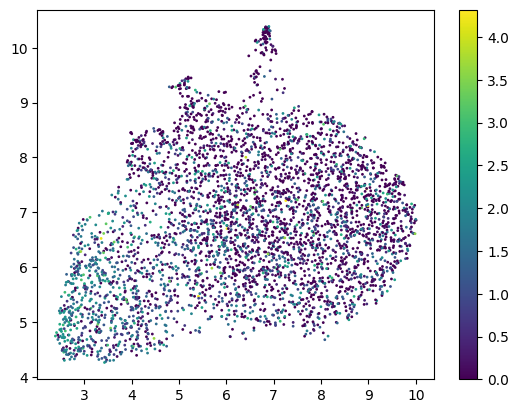

In [93]:
import matplotlib.pyplot as plt
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=z['obs/exp'][:][:,100,:].sum(-1), cmap='viridis', s=1)
plt.colorbar()
plt.show()


In [6]:
import umap
import matplotlib.pyplot as plt
import os

def plot_umap_layers(z, num_blocks=12, embedding_prefix='embeddings/encoder.blocks.', obs_key='obs/exp', obs_index=100):
    """
    Generates and plots UMAP for embeddings from encoder.blocks.0 to encoder.blocks.(num_blocks - 1)

    Parameters:
    - z: data dictionary or h5py-like object with keys like 'embeddings/encoder.blocks.i'
    - num_blocks: number of encoder blocks (default 12)
    - embedding_prefix: prefix for embedding keys
    - obs_key: key for coloring the scatter plot
    - obs_index: index along axis 1 for the obs array (e.g., time or feature index)
    """
    for i in range(num_blocks):
        key = f'{embedding_prefix}{i}'
        print(f"Processing {key}...")

        # UMAP
        embedding = z[key][:]
        umap_result = umap.UMAP(n_components=2).fit_transform(embedding)

        # Color values
        color_values = z[obs_key][:][:, obs_index, :].sum(-1)

        # Plot
        plt.figure(figsize=(6, 5))
        plt.scatter(umap_result[:, 0], umap_result[:, 1], c=color_values, cmap='viridis', s=1)
        plt.colorbar()
        plt.title(f"UMAP of {key}")
        plt.tight_layout()
        # Save figure
        
        filename = os.path.join("/gpfs/home/asun/jin_lab/get/3_aggr_embedding/", f"umap_encoder_block_{i}.png")
        plt.savefig(filename, dpi=300)
        plt.close()  # Close figure to avoid memory buildup

In [7]:
plot_umap_layers(z)

Processing embeddings/encoder.blocks.0...
Processing embeddings/encoder.blocks.1...
Processing embeddings/encoder.blocks.2...
Processing embeddings/encoder.blocks.3...
Processing embeddings/encoder.blocks.4...
Processing embeddings/encoder.blocks.5...
Processing embeddings/encoder.blocks.6...
Processing embeddings/encoder.blocks.7...
Processing embeddings/encoder.blocks.8...
Processing embeddings/encoder.blocks.9...
Processing embeddings/encoder.blocks.10...
Processing embeddings/encoder.blocks.11...
